# Object Detection

方法：

0.	选择一个小物件，比如一个易拉罐，一本书；再选择一个大场景，场景中包含这个小物件
1.	分别对这两幅图（小物件/大场景）进行特征点检测
2.	找到小物件对大场景的特征点匹配，匹配处即我们检测到的小物件。
3.	小物件在原图中的 Bounding Box【就是把小物件框出来的矩形；如果没有手动框出，也可以认为是小图的四个顶点坐标】，经过单应性变换，就是小物件在大场景图中的新边框。

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def my_show(img):
    plt.figure(figsize=(10,10),dpi=100)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [3]:
img1 = cv2.imread('box.png', 0)          # query Image
img2 = cv2.imread('box_in_scene.png',0)  # target Image

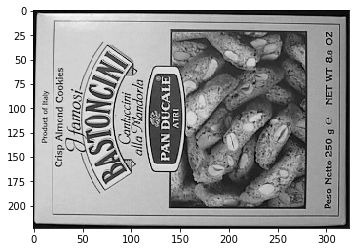

In [4]:
plt.imshow(img1,cmap='gray')

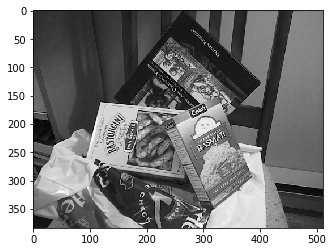

In [5]:
plt.imshow(img2,cmap='gray')

### 特征点检测

In [11]:
def show_key_points(img, kp):
    img_sift = cv2.drawKeypoints(img, kp, outImage=np.array([]),flags=2)
    my_show(img_sift)

In [7]:
# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

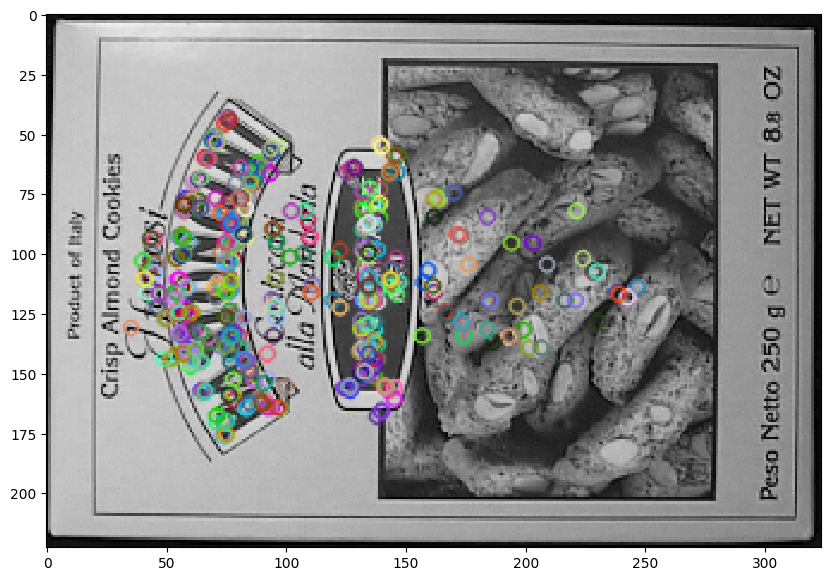

In [12]:
show_key_points(img1, kp1)

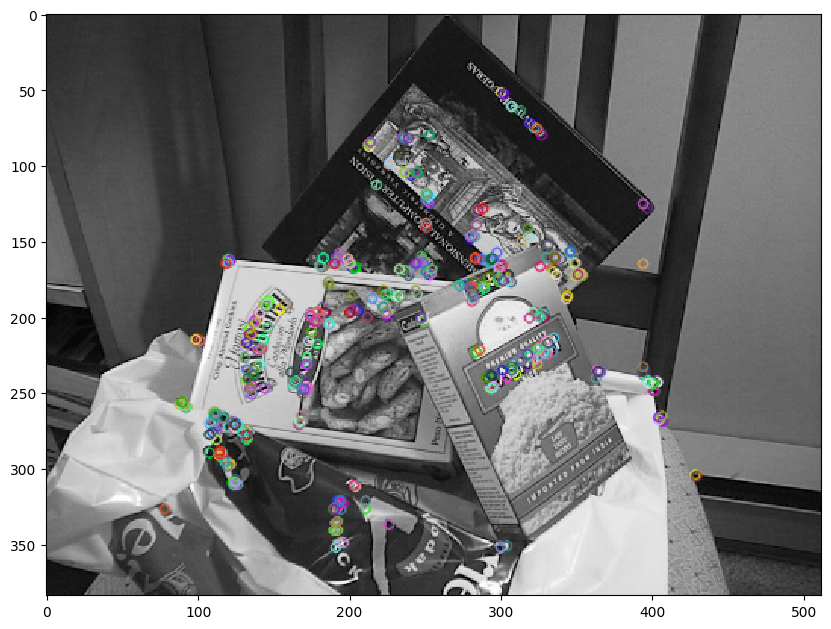

In [13]:
show_key_points(img2, kp2)

### 特征点匹配

In [15]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

good_matches = matches[:10]

In [16]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

In [24]:
draw_params = dict(matchColor = (0,0,255), # draw matches in red color
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches, None,**draw_params)

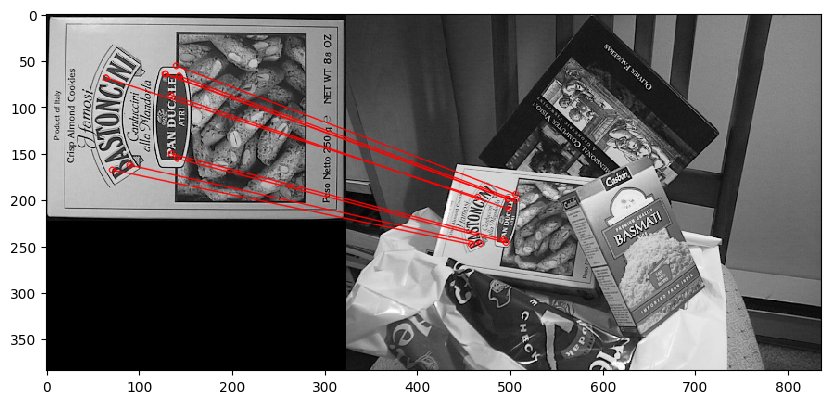

In [25]:
my_show(img3)

### 小物件在原图中的 Bounding Box

In [28]:
dst = cv2.perspectiveTransform(pts,M)
dst += (w, 0)  # adding offset

# Draw bounding box in Red
img3 = cv2.polylines(img3, [np.int32(dst)], True, (0,255,0),2, cv2.LINE_AA)

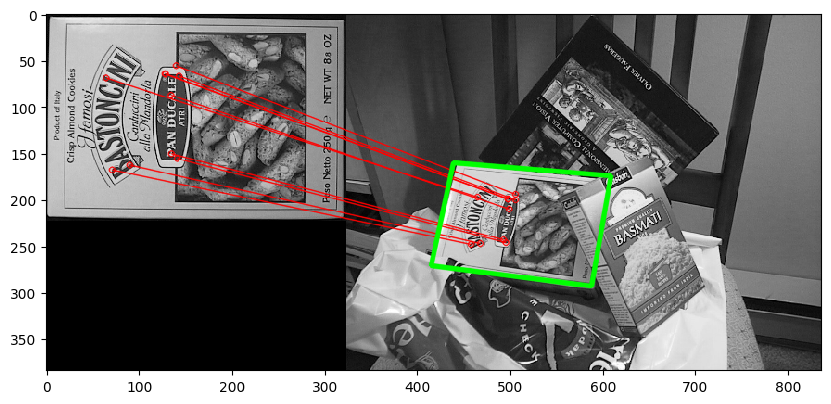

In [29]:
my_show(img3)